### Config Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [ ]:
!kaggle competitions download -c hackathon-online-2022-image-processing

 96% 399M/415M [00:01<00:00, 283MB/s]
100% 415M/415M [00:01<00:00, 268MB/s]


In [ ]:
!unzip /content/hackathon-online-2022-image-processing.zip

Archive:  /content/hackathon-online-2022-image-processing.zip
  inflating: IM_Submit.csv           
  inflating: IM_Test.zipfile         
  inflating: IM_Train.zipfile        


In [ ]:
!mkdir /content/zipfile
!unzip /content/IM_Test.zipfile -d /content/zipfile
!unzip /content/IM_Train.zipfile -d /content/zipfile

Archive:  /content/IM_Test.zipfile
  inflating: /content/zipfile/IM_Test.zipfile  
Archive:  /content/IM_Train.zipfile
  inflating: /content/zipfile/IM_Train.zipfile  


In [ ]:
!mkdir /content/dataset/
!unzip /content/zipfile/IM_Train.zipfile -d /content/dataset
!unzip /content/zipfile/IM_Test.zipfile -d /content/dataset/test
!rm -r /content/zipfile

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
 extracting: /content/dataset/test/IM_Test/IM_Test/5499.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/55.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/550.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/5500.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/5501.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/5502.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/5503.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/5504.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/5505.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/5506.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/5507.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/5508.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/5509.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/551.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/5510.png  
 extracting: /con

### Data preprocessing

In [ ]:
import cv2
import os
import numpy as np
import glob as gb
import tensorflow as tf
from keras.utils import load_img
import matplotlib.pyplot as plt
import PIL

In [ ]:
train_dir = '/content/dataset/train/'
test_dir = '/content/dataset/test/IM_Test/IM_Test/'

In [ ]:
## Check image amount each folder
trainDir_list = []
for folder in os.listdir(train_dir):
  files = gb.glob('/content/dataset/train/'+folder+'/')
  for file in files:
    trainDir_list.append(str(file))
    print("Folder",folder,':',len(os.listdir(str(file))))

Folder 4 : 7458
Folder 0 : 4948
Folder 7 : 5595
Folder 3 : 8497
Folder 1 : 13861
Folder 2 : 10585
Folder 8 : 5045
Folder 6 : 5727
Folder 9 : 4659
Folder 5 : 6882


In [ ]:
batch_size = 32
img_height = 100
img_width = 100
target_input = (img_width, img_height,3)

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 73257 files belonging to 10 classes.
Using 58606 files for training.


In [ ]:
val_data = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 73257 files belonging to 10 classes.
Using 14651 files for validation.


In [ ]:
class_names = train_data.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


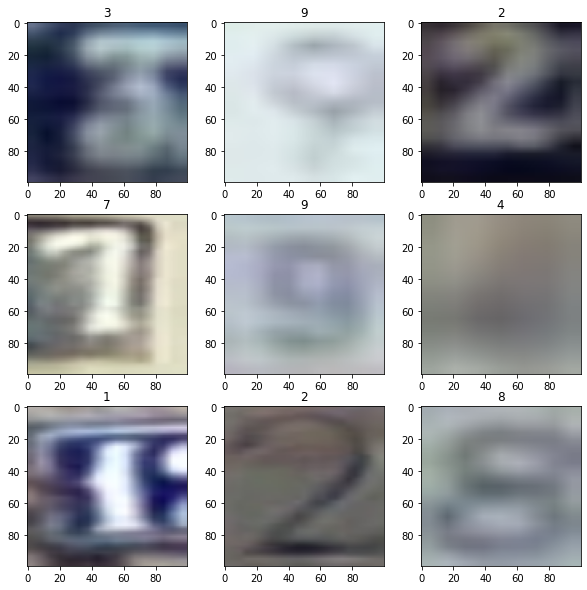

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])

In [ ]:
num_classes = len(class_names)

### Model Building

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras import optimizers

In [ ]:
from tensorflow.keras.applications import vgg16

vgg = vgg16.VGG16(include_top=False, 
                  weights='imagenet',
                  input_shape=target_input)
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                              

In [ ]:
vgg.trainable = True
for layer in vgg.layers[:11]:
    if layer.name[:11] == 'block5_conv':
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
new_vgg = models.Sequential()
new_vgg.add(vgg)
new_vgg.add(layers.Flatten())
new_vgg.add(layers.Dense(128,activation='relu',
                     kernel_initializer='he_uniform',
                     name='fully_connect_1'
                    ))

new_vgg.add(layers.Dropout(0.5,name='dropout_2'))
new_vgg.add(layers.Dense(10,activation='softmax',
                     kernel_initializer='he_uniform',
                     name='output'
                    ))

new_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 fully_connect_1 (Dense)     (None, 128)               589952    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 15,305,930
Trainable params: 13,570,442
Non-trainable params: 1,735,488
_________________________________________________________________


In [ ]:
opt = optimizers.Adam(learning_rate=1e-4)
new_vgg.compile(optimizer=opt,
           loss = 'sparse_categorical_crossentropy',
           metrics=['accuracy'])

In [ ]:
history2 = new_vgg.fit(
  train_data,
  validation_data=val_data,
  epochs=20
)

Epoch 1/20
1832/1832 [==============================] - 145s 73ms/step - loss: 0.7042 - accuracy: 0.7907 - val_loss: 0.3447 - val_accuracy: 0.9022
Epoch 2/20
1832/1832 [==============================] - 134s 73ms/step - loss: 0.3355 - accuracy: 0.9091 - val_loss: 0.3059 - val_accuracy: 0.9138
Epoch 3/20
1832/1832 [==============================] - 133s 73ms/step - loss: 0.2592 - accuracy: 0.9296 - val_loss: 0.2951 - val_accuracy: 0.9208
Epoch 4/20
1832/1832 [==============================] - 133s 73ms/step - loss: 0.2086 - accuracy: 0.9430 - val_loss: 0.3176 - val_accuracy: 0.9298
Epoch 5/20
1832/1832 [==============================] - 133s 73ms/step - loss: 0.1722 - accuracy: 0.9539 - val_loss: 0.3382 - val_accuracy: 0.9243
Epoch 6/20
1832/1832 [==============================] - 133s 73ms/step - loss: 0.1374 - accuracy: 0.9632 - val_loss: 0.3996 - val_accuracy: 0.9262
Epoch 7/20
1832/1832 [==============================] - 133s 73ms/step - loss: 0.1188 - accuracy: 0.9677 - val_loss: 0

In [ ]:
new_vgg.save('my_model2.h5')